## This notebook serves as an illustration of KinoML workflow

### Premises

The aim is to predict the binding free energy $\Delta G$ of a given ligand and a given kinase.

_**How ?**_ 

By building a machine learning (ML) algorithm and an observation model based on physics.

### Challenges
There are several publicly available data sets of bioactivity. However, none of them directly report $\Delta G$.

### Workaround
Use observation models (which are directly derived from physics).

### Toy example: ChEMBL
We are going to use the ChEMBL data set an example, but the workflow stays the same on any other data set available in kinoml (e.g. KinomeScan).

In [1]:
import warnings
warnings.simplefilter("ignore") 
import logging
logging.basicConfig(level=logging.ERROR)

In [2]:
from kinoml.datasets.chembl import ChEMBLDatasetProvider
chembl = ChEMBLDatasetProvider.from_source()

In [3]:
df = chembl.to_dataframe()
df

,Systems,n_components,Measurement,MeasurementType
0,P00533 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,7.387216,pIC50Measurement
1,P35968 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,4.782516,pIC50Measurement
2,P00533 & Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)...,2,6.769551,pIC50Measurement
3,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,6.853872,pIC50Measurement
4,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,5.928118,pIC50Measurement
...,...,...,...,...
203375,P42345 & CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)...,2,8.522879,pKdMeasurement
203376,P42345 & CO[C@H]1CC[C@H](N2C(=O)CNc3ncc(-c4ccc...,2,7.552842,pKdMeasurement
203377,P42345 & CNC(=O)c1cccc(-c2ccc3c(N4CCOC[C@@H]4C...,2,9.853872,pKdMeasurement
203378,P42345 & CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O...,2,9.221849,pKdMeasurement


In [4]:
print("Measurement types:", set(df['MeasurementType']))

Measurement types: {'pKiMeasurement', 'pKdMeasurement', 'pIC50Measurement'}


The measurements that are associated with $pIC_{50}$, $pK_d$, $pK_i$ are given in molar $[M]$ units.

See Chembl website: https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions#what-is-pchembl 

### Subset of ChEMBL

Let us use a subset of 10K systems (data points) for time efficiency.

In [5]:
from kinoml.core.measurements import pIC50Measurement
from kinoml.datasets.chembl import ChEMBLDatasetProvider, _SingleTypeChEMBLDatasetProvider
subset = []
count = 0
for ms in chembl.measurements:
    if isinstance(ms, pIC50Measurement):
        subset.append(ms)
        count += 1
    if count >= 10000:
        break

subchembl = ChEMBLDatasetProvider([_SingleTypeChEMBLDatasetProvider(subset)])
subchembl

<ChEMBLDatasetProvider with 10000 pIC50Measurement measurements and 8514 systems>

In [6]:
subdf = subchembl.to_dataframe()
subdf

,Systems,n_components,Measurement,MeasurementType
0,P00533 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,7.387216,pIC50Measurement
1,P35968 & Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F...,2,4.782516,pIC50Measurement
2,P00533 & Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)...,2,6.769551,pIC50Measurement
3,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,6.853872,pIC50Measurement
4,P06239 & Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C...,2,5.928118,pIC50Measurement
...,...,...,...,...
9995,Q9Y243 & CC(C)Cc1nc(-c2ccccc2)c(-c2ccc(CN3CCC(...,2,4.660151,pIC50Measurement
9996,P31749 & O=C(O)c1ccc2nc(-c3ccc(CN4CCC(n5c(=O)[...,2,6.619789,pIC50Measurement
9997,P31751 & O=C(O)c1ccc2nc(-c3ccc(CN4CCC(n5c(=O)[...,2,6.551294,pIC50Measurement
9998,P31749 & O=C(O)c1ccc2nc(-c3ccccc3)c(-c3ccc(CN4...,2,6.779892,pIC50Measurement


### Featurization
#### Featurize the ligand

Here we use the simple example of the Morgan fingerprint, but any featurizer available in KinoML could be applied (for example the graph featurizer).

#### Featurize the kinase
We use the standardized binding site sequence composition featurizer for the kinase, but any other available featurizer in KinoML could be applied. 

In [8]:
from kinoml.features.ligand import SmilesToLigandFeaturizer, MorganFingerprintFeaturizer
from kinoml.features.protein import AminoAcidCompositionFeaturizer
from kinoml.features.core import ScaleFeaturizer, Concatenated, Pipeline

morgan_featurizer = Pipeline([SmilesToLigandFeaturizer(), MorganFingerprintFeaturizer(nbits=1024, radius=2)])
composition_featurizer = Pipeline([AminoAcidCompositionFeaturizer(), ScaleFeaturizer()])
concat_featurizers = Concatenated([morgan_featurizer, composition_featurizer], axis=0)

# prefeaturize everything
subchembl.featurize(concat_featurizers)

Featurizing systems...:  49%|████▊     | 4132/8514 [01:55<02:09, 33.90it/s]RDKit WARNING: [16:15:46] Conflicting single bond directions around double bond at index 14.
RDKit WARNING: [16:15:46]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [16:15:46] Conflicting single bond directions around double bond at index 14.
RDKit WARNING: [16:15:46]   BondStereo set to STEREONONE and single bond directions set to NONE.
Featurizing systems...: 100%|██████████| 8514/8514 [04:46<00:00, 29.74it/s]


### Model
We use a shallow neural network with only one hidden layer. The output of the model is a single node, which represents $\Delta g$, the unitless binding free energy
$$
\Delta g = \frac{\Delta G}{k_B T}.
$$

This model is very simple, but any model available in KinoML can be used (e.g. Graph Neural Network).

### Idea behind the _observation_ model

_Recall:_
$$
\Delta g = \frac{\Delta G}{k_B T},
$$
where $k_B, T$ are the Boltzmann constant and temperature, respectively. 

As stated above, we would like to predict the (unitless) binding free energy $\Delta g$ which is not reported in public data sets.


However there are physics-based models which relate measured quantities (such as $K_d$) to the desired $\Delta g$.

In order to use all available data and combine different data sets, for every measurement type, we define a function based on the physics that maps $\Delta g$ to the measured data type.

#### ChEMBL
The measurement types available in ChEMBL are:
- $IC_{50}$
- $K_i$
- $K_d$

#### KinomeScan
The measurement type in KinomeScan is the percent displacement
- $\%displ.$

### Define a _observation_ function to be applied on $\Delta g$

This _observation_ function is adapted to each measurement type.

#### For $K_d$ measurements
The dissociation constant $K_d$ is defined as (see https://doi.org/10.1002/wcms.1455)
$$
K_d = \frac{[L][P]}{[LP]},
$$
where $[L]$, $[P]$, $[LP]$ are the ligand, protein and complex concentrations, respectively. From the article, we have
$$
\Delta G = -k_B T \ln (C*K_b),
$$
where $C$ is the standard concentration of 1 [M].

Using the fact that $K_b = \frac{1}{K_d}$, we obtain
$$
\frac{\Delta G}{k_B T} = - \ln \Big( \frac{C}{K_d}\Big),$$
therefore,
$$
\frac{\Delta G}{k_B T} = \ln \Big( \frac{K_d}{C}\Big),
$$
and finally
$$
K_d = \exp \Big( \frac{\Delta G}{k_B T}\Big) * C.
$$
Putting the units in the equation, we have:
$$
K_d [M] = \exp \Big( \frac{\Delta G}{k_B T}\Big) * C[M].
$$


We define the following observation model for $K_d$ as
$$
\mathbf{F}_{K_d}(\Delta g) = exp[-\Delta g] * C [M].
$$

However, it is more common to use $pK_d$ values when training a ML model. 

We recall the following
$$
pK_d [M] = -log_{10}(K_d [M]),
$$
and define
$$
\mathbf{F}_{pK_d}(\Delta g) = -log_{10}(exp[-\Delta g] * C [M]).
$$


#### For $K_i$ measurements
We make the assumption that $K_i \approx K_d$ and therefore $\mathbf{F}_{K_i} = \mathbf{F}_{K_d}$ and $\mathbf{F}_{pK_i} = \mathbf{F}_{pK_d}$.

#### For $IC_{50}$ measurements


We use the Cheng Prusoff equation here.

The [Cheng Prusoff](https://en.wikipedia.org/wiki/IC50#Cheng_Prusoff_equation) equation states the following relationship

\begin{equation}
K_i = \frac{IC_{50}}{1+\frac{[S]}{K_m}}.
\end{equation}

We make the assumption
$$
K_i \approx K_d.
$$

Under this assumption, the Cheng-Prusoff equation becomes
$$
IC_{50} \approx \Big({1+\frac{[S]}{K_m}}\Big) * K_d.
$$

We define the following function, using the observation model for $K_d$ defined above
$$
\mathbf{F}_{IC_{50}}(\Delta g) = \Big({1+\frac{[S]}{K_m}}\Big) * \mathbf{F}_{K_d}(\Delta g) = \Big({1+\frac{[S]}{K_m}}\Big) * exp[-\Delta g] * C[M].
$$

Given $IC_{50}$ values given in molar units, we obtain $pIC_{50}$ values in molar units using the tranformation
$$
pIC_{50} [M] = -log_{10}(IC_{50}[M])
$$

Finally the observation model for $pIC_{50}$ values is
$$
\mathbf{F}_{pIC_{50}}(\Delta g) = -log10\Big(({1+\frac{[S]}{K_m}}) * exp[-\Delta g] * C[M]\Big)
$$


#### For KinomeScan measurements  (check!)
For the percent displacement measurements available from KinomeScan, we make the assumption (see JDC's notes) that

$$
D([I]) \approx \frac{1}{1 + \frac{K_d}{[I]}}
$$

For KinomeSCAN assays, all assays are usually performed at a single concentration, $ [I] \sim 1 \mu M $.

We therefore define the following function
$$
\mathbf{F}_{KinomeScan}(\Delta g, [I]) = \frac{1}{1 + \frac{exp[-\Delta g] * 1[M]}{[I]}}.
$$

### Observation model

In [12]:
observation_models = subchembl.observation_models(backend="pytorch")
observation_models

[<function kinoml.core.measurements.pIC50Measurement._observation_model_pytorch(dG_over_KT, substrate_conc=1e-06, michaelis_constant=1, inhibitor_conc=1, **kwargs)>]

### Application

Apply observation model to predicted $\Delta g$ and compute loss function w.r.t to the learnable parameters.

In [9]:
import torch
from kinoml.ml.torch_models import NeuralNetworkRegression
from tqdm.auto import trange, tqdm

# Use DataLoader for minibatches
datasets = subchembl.to_pytorch()
loaders = [dataset.as_dataloader(batch_size=5, shuffle=True) for dataset in datasets]

### Define a loss function
Herer we use the mean squarred error as a loss, but a more complex function which can account for different measurement types will be used.

In [10]:
loss_function = torch.nn.MSELoss() # Mean squared error

### A few model settings

In [11]:
# precompute input size
input_size = datasets[0].estimate_input_size()
# Initialize model
model = NeuralNetworkRegression(input_size=input_size[0])
# Optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

nb_epoch = 100

### Training loop

In [13]:
loss_timeseries = []
ys = []
range_epochs = trange(nb_epoch, desc="Epochs (+ featurization...)")
for epoch in range_epochs:
    cumulative_loss = 0.0
    ys.append([])
    for i, loader in enumerate(loaders):
        for j, (x, y) in enumerate(loader):

            # Clear gradients
            optimizer.zero_grad()

            # Obtain model prediction given model input
            delta_g = model(x)

            # with observation model
            prediction = loader.dataset.observation_model(delta_g)
            
            y = y.reshape(prediction.shape)

            ys[-1].append((delta_g, prediction, y))

            # loss between true and predicted values
            loss = loss_function(prediction, y)

            # Obtain loss for the predicted output
            cumulative_loss += loss.item()

            # Gradients w.r.t. parameters
            loss.backward()

            # Optimizer
            optimizer.step()
            if j % 2000 == 0:    # print every 2000 mini-batches
                range_epochs.set_description(f"Epochs (loss={cumulative_loss / 2000:.2e})")
                cumulative_loss = 0.0
            
    loss_timeseries.append(cumulative_loss)

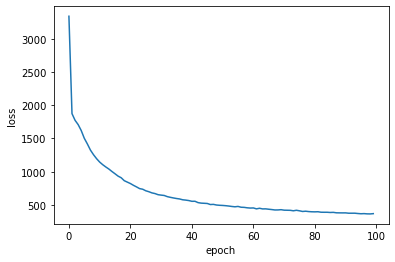

In [14]:
import matplotlib.pyplot as plt
f = plt.figure()
plt.plot(loss_timeseries)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Model performance on the whole data set

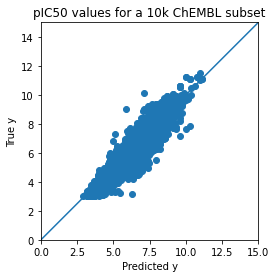

R2: Goodness of fit measure: 0.90
MSE: 0.18
RMSE: 0.42
MAE: 0.30


In [15]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

model_input = torch.tensor(datasets[0].systems).type(torch.FloatTensor)
true = datasets[0].measurements

delta_g = model(model_input)
prediction = datasets[0].observation_model(delta_g).detach().numpy()


fig, ax = plt.subplots()
ax.scatter(prediction, true)
ax.set(xlim=(0, 15), ylim=(0, 15))
ax.set_xlabel("Predicted y")
ax.set_ylabel("True y")
ax.set_title("pIC50 values for a 10k ChEMBL subset")
x = np.linspace(0, 15, 10)
ax.plot(x, x)
ax.set_aspect('equal', adjustable='box')
plt.show()

r2 = r2_score(true, prediction)
print(f"R2: Goodness of fit measure: {r2:.2f}")
if all(elem==prediction[0] for elem in prediction):
    print("All outputs are equal: ")
mse = mean_squared_error(true, prediction)
mae = mean_absolute_error(true, prediction)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

### Illustrative workflow

Workflow illustration with one measurement.

![unique_measurement](images/KinoML_Workflow-single.png)

## Multiple data sets and measurements

When we have more than a single measurement type for a protein-ligand system, we can define a more complex loss function:

$$
L(\mathbf{\hat{y}}, \mathbf{y}) = 
\sum_{i=1}^{M} \alpha_i \cdot
\mathbf{1} \{ mse(\mathbf{\hat{y}_i}, \mathbf{y_i}) \text{ if assay type i exists}\},
$$ 
where the weight $\alpha_i$ would be determined according to the range of the different measurement types.

E.g.

$\alpha_{K_d} = \alpha_{K_i} = 1$ and $\alpha_{IC50} = 1/2$

### Illustrative workflow

Workflow illustration with multiple measurements

![multiple_measurements](images/KinoML_Workflow-multiple.png)